In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML, Image
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [2]:
x = np.array([[0., 0.5], [0.5, -0.3], [1., 1.5], [1.5, .4], [2., .6]])
t = [0., 1., 2., 3., 4.]
gamma = np.array([.2,.25])
burnin = 100
n = 100

In [3]:
def brownianbridgeM(gvec, xin, tin, n):
    h = (tin[1]-tin[0])/n
    tvec = tin[0] + (1+np.arange(n))*h
    h12 = np.sqrt(h)
    wincs = np.random.multivariate_normal(mean=np.zeros(len(gvec)),
                                          cov=h*np.diag(np.square(gvec)),
                                          size=n)
    w = np.cumsum(wincs,axis=0).T
    bridge = xin[0,:,None] + w
    bridge -= ((tvec - tin[0])/(tin[1]-tin[0]))*(w[:,n-1,None] + xin[0,:,None] - xin[1,:,None])
    return tvec, bridge

# girsanov LOG likelihood
def girsanovM(gvec, path, dt):
    b = drift(path)
    u = np.dot(np.diag(np.power(gvec,-2)), b)
    int1 = np.tensordot(u[:,:-1], np.diff(path,axis=1))
    # int2 = np.tensordot(u, b)
    u2 = np.einsum('ij,ji->i',u.T,b)
    int2 = np.sum(0.5*(u2[1:] + u2[:-1]))*dt
    r = int1 - 0.5*int2
    return r

In [4]:
# define drift function
def drift(x):
    f = np.zeros(x.shape)
    f[0,:] = x[1,:]
    f[1,:] = -np.sin(x[0,:])
    return f

In [5]:
# MH sampler
def em2d(interval):
    h = (t[1]-t[0])/n
    tout, xcur = brownianbridgeM(gamma,x[interval:interval+2],t[interval:interval+2],n)
    oldlik = girsanovM(gvec=gamma, path=xcur, dt=h)
    arburn = np.zeros(burnin)
    for jj in range(burnin):
        # _, prop = brownianbridgeM(gamma,xaux,t,n)
        # prop += traj.T
        _, prop = brownianbridgeM(gamma,x[interval:interval+2],t[interval:interval+2],n)
        proplik = girsanovM(gvec=gamma, path=prop, dt=h)
        rho = proplik - oldlik
        if (rho >= np.log(np.random.uniform())):
            xcur = prop
            oldlik = proplik
            arburn[jj] = 1

#     print("Acceptance rate during burn-in:", np.mean(arburn))

    _, prop = brownianbridgeM(gamma,x[interval:interval+2],t[interval:interval+2],n)
    proplik = girsanovM(gvec=gamma, path=prop, dt=h)
    rho = proplik - oldlik
    if (rho >= np.log(np.random.uniform())):
        xcur = prop
        oldlik = proplik
#     _ = plt.plot(xcur[0,:],xcur[1,:], 'r')
    return tout, xcur[0, :], xcur[1, :]

In [9]:
def animate2d(i):
    dt = 5 / n
    tout = np.arange(0.0, 4. + dt, dt)
    samples = np.zeros((2, tout.shape))
    for interval in range(x.shape[0] - 1):
        tout, samples[0, interval*n:(interval+1)*n], samples[1, interval*n:(interval+1)*n] = em2d(interval)
    line.set_data(tout, samples)
    return (line,)

NameError: name 'tout' is not defined

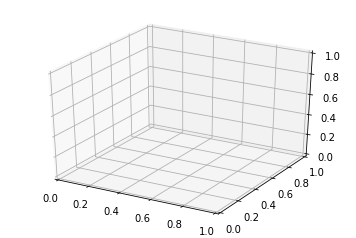

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

for i in range(100):
    ax.plot(tout, samples[0, i, :], samples[1, i, :], color='grey', alpha=0.2)
plt.grid()
ax.plot([t[3]], [x[3, 0]], [x[3, 1]], 'bo')
ax.plot([t[4]], [x[4, 0]], [x[4, 1]], 'bo')
ax.plot(tout, np.mean(samples[0], axis=0), np.mean(samples[1], axis=0), 'r', linewidth=3)
plt.show()

In [10]:
anim = animation.FuncAnimation(fig, animate2d, frames=50, interval=200, blit=True)
anim

TypeError: 'tuple' object cannot be interpreted as an integer

In [ ]:
anim.save('diffbridge2d.gif', writer='imagemagick', fps=5)

In [ ]:
Image(url='diffbridge2d.gif')